# 1.下载数据集


导入相关的软件包，下载包含图像及其真值的文件，将图像及其真值存储在一个可用的CSV文件中

In [ ]:
!pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
import selectivesearch
from google.colab import files
files.upload() # upload kaggle.json file which you can get
# by clicking on Create New API token in your personal account
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

指定图像的位置并读取已下载CSV文件中的真值

In [ ]:
IMAGE_ROOT = 'images/images'
DF_RAW = pd.read_csv('df.csv')
print(DF_RAW.head())

# 2.准备数据集（完成对数据集的准备工作）

①获取每个图像及其对应的类别和边界框真值



②获取每个图像的区域建议，及其对应的IoU，以及区域建议关于真值的修正量delta

③为每个类别分配数字标签（包含一个额外的背景类，即除公交车类和卡车类之外的类，或者他与真值边界框之间的IoU小于阈值）

④ 将每个区域的大小调整为通用大小，以便将其传递给网络结构

  定义一个类，用于返回图像及其类别、真值、文件路径

In [ ]:
# 定义一个类，返回图像、真值、类别、文件路径
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        # 获取数据帧中唯一的ImageID值(self.unique_iimage),这样做是因为【一个图像可以包含多个目标】，所以可以有多个行对应相同的ImageID值
        # df['ImageID']：这部分选取了 DataFrame df 中的 'ImageID' 列。
        # unique()：这部分获取了选定列中的唯一值，即去除重复值，返回一个包含所有唯一值的数组或列表
        self.unique_images = df['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        # 从 DataFrame 中选取了 'XMin'、'YMin'、'XMax' 和 'YMax' 这四列，并将它们的值存储到名为 boxes 的数组中。
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        # 按照图像的尺寸缩放边界框坐标。
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path

检查某个样本图像及其对应的类别和边界框真值

In [ ]:
# DF_RAW 是原始数据集的 DataFrame，DataFrame 是 Pandas 库中用于处理表格数据的主要数据结构，类似于电子表格或数据库表。
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[9]
show(im, bbs=bbs, texts=clss, sz=10)

定义extract_iou和extract_candidates函数

In [ ]:
# 利用SelectiveSearch方法生成区域建议
def extract_candidates(img):
    # img_lbl 是一个与输入图像尺寸相同的标签图像，用于标记每个区域，regions 是一个包含所有候选区域的列表。
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    # 只获取那些大于图像总区域5%且不超过100%的候选区域，并将其返回
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates
# 计算IoU（交并比）
# epsilon 是一个可选参数，用于处理除以零的情况(两个边界框的并集为0)，默认值为 1e-5。
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

#3.获取区域建议和关于真值的偏移量

⚓创建对应模型的输入和输出值。模型输入为使用Selectivesearch方法提取的候选区域，输出是与候选区域相对应的目标类别，以及候选区域相对于与其重叠最多的边界框（如果候选区域包含一个目标）的偏移量

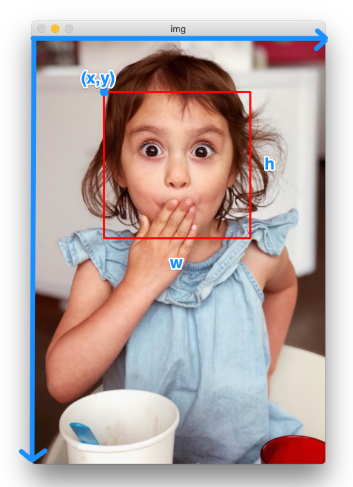


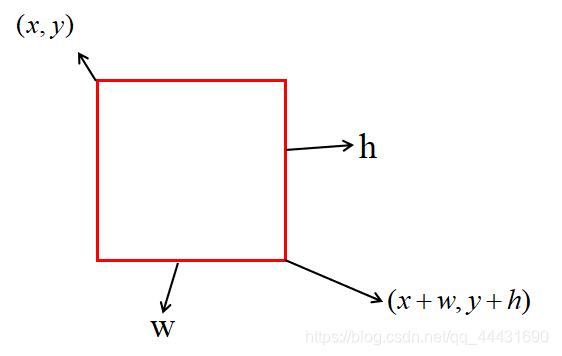

In [14]:
# 1.初始化一个空列表来存储文件路径（FPATHS）、边界框真值（GTBBS）、目标的类别（CLSS）、边界框与区域建议的delta偏移量（DELTAS）、区域建议的位置（ROIS）以及区域建议与真值之间的IoU（IOUS）
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []

# 2.循环遍历数据集并填充上述初始化列表

# 使用前500个数据进行演示性训练
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    H, W, _ = im.shape
    # 使用extract_candidates函数从图像(im)中获取候选区域的绝对像素值
    candidates = extract_candidates(im)
    # 在计算机图像中，通常采用的是以图像的左上角为原点 (0,0)
    # 注意，XMin,YMin,XMax,YMax 是下载数据帧中的图像形状比例。对于提取的候选区域，需要将区域坐标从(x,y,w,h)转换为（x,y,x+w,y+h）
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    # 候选对象的iou、区域建议位置、边框偏移量、每个图像中每个候选对象的类别
    ious, rois, deltas, clss = [], [], [], []
    # 存储一个图像中所有候选对象关于真值的IoU，其中bbs是图像中不同目标的真值边界框
    # .T: 这是一个 NumPy 数组的转置操作，用于将交并比矩阵的行列互换，以便每行对应于真实边界框，每列对应于候选边界框。
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    # 循环遍历每个候选对象并存储候选对象的XMin(cx)、YMin(cy)、XMax(cX)、YMax(cY)值
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        # 在获取ious列表的列表时，根据所有已经计算过的真值边界框，提取对应于候选对象的IoU
        candidate_ious = ious[jx]
        # 找到最高IoU的候选对象(best_iou_at)索引和对应的真值(best_bb)
        best_iou_at = np.argmax(candidate_ious)  #寻找candidate_ious中的最大值，并返回其索引
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        # 如果候选对象的IoU(best_iou)大于阈值（0.3），那么分配预期对应的类别标签，否则将其划分为背景类别
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        # 获取所需的偏移量(delta),以便将 当前区域建议 转换为 最佳区域建议的候选方案(即边界框真值)——best_bb
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])  #计算了一组相对于中心点的偏移量，然后将这些偏移量进行了归一化
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H])) #区域建议位置 rois
    # 文件路径（FPATHS）、区域建议与真值之间的IoU（IOUS）、目标的类别（CLSS）、区域建议的位置（ROIS）、目标的类别（CLSS）、边界框与区域建议的delta偏移量（DELTAS）和边框真值(GTBBS)
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
# 获取图像路径名称，并将获取的所有信息FPATHS, GTBBS, CLSS, DELTAS, ROIS存储在一个列表中
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS] # stem(f) 从文件路径中提取文件名的函数，如/path/to/file/example.jpg'，那么 stem(f) 将返回 'example'
# 创建了一个列表，其中包含了变量FPATHS、GTBBS、CLSS、DELTAS和ROIS。然后通过列表推导式，将每个变量都放入一个新的列表中，最终将这个新的列表解包给了FPATHS、GTBBS、CLSS、DELTAS和ROIS这五个变量。
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

# 3.给每个类别分配索引（背景类别的索引为0，公交车类别的索引为1，卡车类别的索引为2）
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

KeyboardInterrupt: 

# 4.创建训练数据

In [ ]:
# 1.定义图像归一化函数
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
# 2.定义用于实现图像(img)预处理的函数(preprocess_image),完成通道切换、图像归一化，并将图像数据注册到设备上
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()

# 定义用于预测类别的函数decode
def decode(_y):
    # 从变量 _y 中取出最大值，并沿着指定的轴（通常是最后一个轴，即 -1）返回对应的索引值，也就是预测的类别。
    _, preds = _y.max(-1)
    return preds

# 3. 使用预处理步骤获得的区域建议和前文获得的真值数据定义数据集（RCNNDataset）
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)

    # 提取区域建议，以及其他与目标类别和边界框偏移量相关的真值
    def __getitem__(self, ix):
        # 对象 self 中位于索引 ix 处的文件路径转换为字符串，并将结果存储在变量 fpath 中 || str()：这是 Python 内置函数，用于将对象转换为字符串类型
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1] #BGR to RGB||... 表示选择所有的前面的维度，而 ::-1 表示沿着最后一个维度（颜色通道）逆序排列
        H, W, _ = image.shape
        sh = np.array([W,H,W,H]) #创建了一个包含四个元素的 NumPy 数组 sh
        gtbbs = self.gtbbs[ix]  #边框真值
        rois = self.rois[ix]   #区域建议的位置
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix] #边界框与区域建议的delta偏移量
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs] #image[y:Y, x:X] 表示从原始图像 image 中截取一个子图像，这个子图像的左上角坐标为 (x, y)，右下角坐标为 (X, Y)
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    # 实现对图像大小的调整和归一化处理(preprocess_image)
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            # [None]：将预处理后的子图像添加一个额外的维度，这是因为大多数深度学习模型的输入是一个四维数组，第一个维度表示样本数量，通常为 1。
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)  #将列表 crops 中的元素逐个添加到列表 input 的末尾
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device) #将列表 input 中的所有张量（tensor）连接起来，形成一个更大的张量，并将结果转移到指定的计算设备 device 上。
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas


In [ ]:
# 4.创建训练数据集和验证数据集，以及数据加载器
n_train = 9*len(FPATHS)//10   #样本总数的90%作为训练的样本数量
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train]) #:n_train 表达式表示一个切片操作，用于从列表的开头提取前 n_train 个元素
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])  #从列表的第 n_train 个元素开始直到列表的末尾，包括第 n_train 个元素

from torch.utils.data import TensorDataset, DataLoader
# collate_fn=train_ds.collate_fn指定了在组装单个样本成批次时要使用的函数
# drop_last=True 指定了当数据集的样本数量不能被批次大小整除时是否丢弃最后一个不完整的批次。在这里，设置为 True 表示丢弃最后一个不完整的批次，确保每个批次都具有相同的大小。
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

# 5. R-CNN网络架构
（1）定义VGG模型的主干网

（2）使用预训练模型获取经过归一化剪裁后的特征

（3）在VGG主干网上附加一个带有sigmoid激活的线性层来预测区域建议的类别

（4）附加一个线性层用于预测四个边界框偏移量

（5）分别为两个输出定义损失计算公式（一个用于预测类别，另一个用于预测四个边界框偏移量）

（6）训练用于预测区域建议类别和四个边界框偏移量的模型

1. 定义VGG模型的主干网

In [ ]:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().to(device) #.eval() 方法将模型设置为评估模式。在评估模式下，模型的行为可能会发生变化，例如在训练时使用的 dropout 层可能会被禁用，以便产生稳定的预测结果。

2. 定义RCNN网络模块

In [ ]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 定义主干网（self.backbone）、类别得分的计算公式(self.cls_socre)，以及边界框偏移量(self.box)
        feature_dim = 25088  # VGG 网络中最后一个卷积层的输出大小为 7x7x512，所以特征向量的维度为 7x7x512 = 25088（假设输入图像大小为 224x224）
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target)) #len(label2target) 返回了 label2target 字典中键值对的数量 （背景类别的索引为0，公交车类别的索引为1，卡车类别的索引为2）
        self.bbox = nn.Sequential( nn.Linear(feature_dim, 512),
                       nn.ReLU(),   #接受一个实数作为输入，如果输入小于等于 0，则输出为 0；如果输入大于 0，则输出等于输入值。
                       nn.Linear(512, 4), #边界框的左上和右下值[XMin,YMin,XMax,YMax]
                       nn.Tanh(),)   #Tanh（双曲正切）是另一个常用的激活函数，它将输入压缩到区间 [-1, 1] 内
        #分别定义对应于类别预测（self.cel）和边界框偏移量回归(self.sl1)的损失函数
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
    # 定义前馈方法、使用VGG主干网（self.backbone）获取图像特折(feat),然后，分别使用[分类方法]和[边界框回归分析方法]获取类别概率(cls_score)和边界框偏移量(bbox)
    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
    # 定义损失函数计算公式（如果实际类别是背景类别，则不计算相应的偏移量回归损失）
    # probs：模型预测的类别概率。_deltas：模型预测的边界框偏移量。labels：真实的类别标签。deltas：真实的边界框偏移量
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 0) #返回了一个张量xs， 其中存储了所有满足条件 labels != 0 的元素的索引。
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            # 用于创建一个新的张量，该张量与原始张量共享数据，但不再与计算图相关联，也就是说不再保留梯度信息。
            # detection_loss + self.lmb * regression_loss 得到一个综合的损失函数，用于同时优化分类和回归任务。
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

3. 定义train_batch函数

In [ ]:
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    # 比较了模型预测的类别标签 clss 与真实的类别标签 decode(_clss) 是否相等，然后将比较结果存储在 accs 中。（True or False）
    # decode(_clss)--解码操作
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    # loss_detach 与 loss 具有相同的数值，但是不再保留梯度信息，也不再与原始计算图相关联。这种做法可以避免不必要的梯度计算，从而提高计算效率。
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

4. 定义validate_batch函数

In [ ]:
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

5. 创建一个模型对象，获取损失标准，然后定义优化器和轮数

In [ ]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

6. 通过不断增加轮数进行模型训练

In [ ]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, optimizer, criterion)
        pos = (epoch + (ix+1)/_n)   # 表示进度
        log.record( pos,
              trn_loss=loss.item(),
              trn_loc_loss=loc_loss,
              trn_regr_loss=regr_loss,
              trn_acc=accs.mean(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, loc_loss, regr_loss, accs = validate_batch(inputs, rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record( pos,
              val_loss=loss.item(),
              val_loc_loss=loc_loss,
              val_regr_loss=regr_loss,
              val_acc=accs.mean(), end='\r') #'\r'--回车符

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

# 6. 对新图像进行预测

（1）从新图像中提取区域建议

（2）归一化调整每个区域建议的大小

（3）对加工过的结果进行前馈计算，以进行目标分类和偏移量的预测

（4）使用非极大抑制方法获取以最高置信度包含目标的边界框

1. 定义test_predictions函数以对新图像进行预测

In [15]:
def test_predictions(filename, show_output=True):
    # 读取图像并提取候选图像
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    # 循环调整候选图像的大小并对图像进行预处理
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    # 预测目标类和边界框的偏移量
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        # 使用 softmax 函数对模型输出的原始概率分布 probs 进行归一化处理，得到归一化后的概率分布。-1 表示在最后一个维度上进行 softmax 操作，通常用于处理分类任务中的概率分布。
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)       #-1 表示在最后一个维度上进行操作
    # 提取不属于背景类别的候选项，并将其与预测的边界框偏移量相加
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)

    # 使用非极大抑制nms方法消除重复的边界框（IoU>0.05的边界框被认为是重复的）。在这些重复的边界框中，我们选择置信度最高的边界框，并丢弃其余的边界框
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    # 获取置信度最高的边界框
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    # 将预测的边界框绘绘制在图像上
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf



2. 对新图像执行上述函数

In [ ]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[7]
test_predictions(fpath)